This project demonstrates how to use PCA for dimensionality reduction, visualizaion, and a preprocessing step before classification.
The project performs two types of PCA fitting:
- PCA with 95% variance retention: Used to reconstruct digit images with minimal loss of information.
- PCA with only 10 components: Used inside a logistic regression pipeline to demonstrate how aggressive dimensionality reduction affects model accuracy.
The project also inclues a 2D PCA visualization of the dataset, plots of explained variance, and a bonus idea for trying PCA on the higher-resolution
MNIST dataset.

In [3]:
# Section 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

In [5]:
# Section 2: Load and split data
# X and y features are separate arrays
X, y = load_digits(return_X_y=True, as_frame=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42, stratify=y)

In [7]:
# Section 3: Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [79]:
# Section 4: Fit PCA to explain 95% variance
# Initialy, we use n_components=0.95 to retain 95% of the total variance, 
# but to create a stronger difference in model performance we later set n_components to 10.
pca_full = PCA(n_components=.95, random_state=42)
pca_10 = PCA(n_components=10, random_state=42)
X_train_pca = pca_full.fit_transform(X_train_scaled)
X_test_pca = pca_full.transform(X_test_scaled)
X_train_pca_10 = pca_10.fit_transform(X_train_scaled)
X_test_pca_10 = pca_10.transform(X_test_scaled)

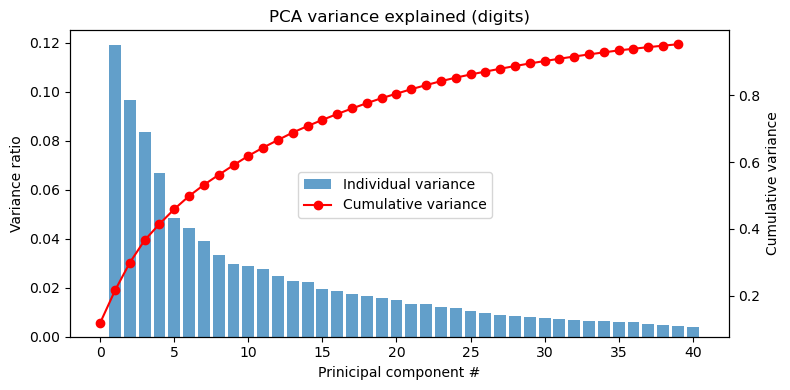

In [67]:
# Section 5: Plot variance explained
fig, ax1 = plt.subplots(figsize=(8, 4))
# 'bars' stores the bar container object, which we later use to create a correct legend.
bars = ax1.bar(
    range(1, len(pca_full.explained_variance_ratio_) + 1),  # The x-coordinates where the bars are placed
    pca_full.explained_variance_ratio_,  # The height of the bars
    alpha=0.7,  # Transparancy
    label="Individual variance"
)
ax2 = ax1.twinx()    # ax1 and ax2 share the same x-axis, but have difference y-axis values (Right and Left)
line, = ax2.plot(
    np.cumsum(pca_full.explained_variance_ratio_),  # plots the cumulative sum of the components
    marker="o", 
    color='red', 
    label="Cumulative variance"
)
ax1.set_xlabel("Prinicipal component #")
ax1.set_ylabel("Variance ratio")
ax2.set_ylabel("Cumulative variance")
ax1.set_title("PCA variance explained (digits)")

# Add a legend
fig.legend(
    handles=[bars, line],
    labels=[ "Individual variance", "Cumulative variance"],
    loc = "center"
)
plt.tight_layout()
plt.show()

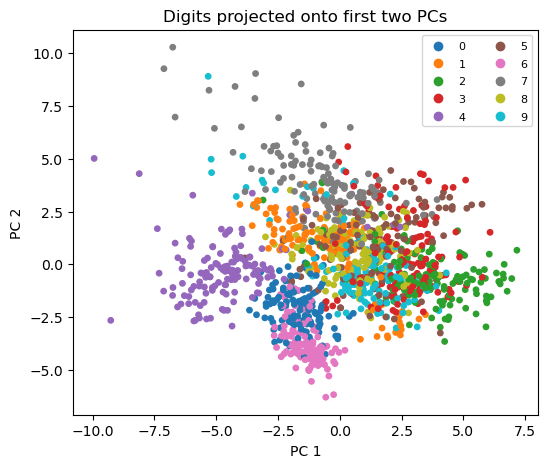

In [90]:
# Section 6: 2-D visualization (first two PCAs)
pca_2 = PCA(n_components=2, random_state=42)
X_train_2d = pca_2.fit_transform(X_train_scaled)

plt.figure(figsize=(6,5))
# 'scatter' is a PathCollection object that holds all the points plotted by plt.scatter(), including their colors, sizes, and positions.
# It allows us to later extract legend elements automatically.
scatter = plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, 
                      cmap = "tab10", s=15)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Digits projected onto first two PCs")
handles, labels = scatter.legend_elements()
plt.legend(handles, labels, loc="best", ncol=2, fontsize=8)
plt.show()

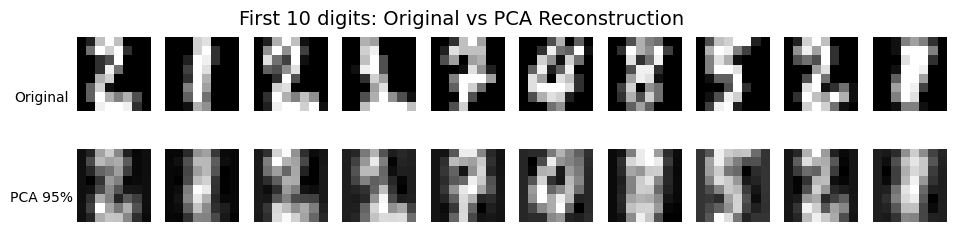

In [138]:
# Section 7: Visualize digits before and after PCA reconstruction

#Inverse transformation to reconstruct images
X_train_reconstructed = pca_full.inverse_transform(X_train_pca)
X_train_reconstructed = scaler.inverse_transform(X_train_reconstructed)

# Create subplots
fig, axes = plt.subplots(2, 10, figsize=(10, 2.5))

# plot original images (top row)
for i, ax in enumerate(axes[0]):
    ax.imshow(X_train[i].reshape(8, 8), cmap="gray")
    ax.set_axis_off()
    
# Plot Reconstructed images (buttom row)
for i, ax in enumerate(axes[1]):
    ax.imshow(X_train_reconstructed[i].reshape(8, 8), cmap="gray")
    ax.set_axis_off()

# Add row labels (Original and PCA 95%)
fig.text(0.08, 0.63, 'Original', va='center', ha='center', fontsize=10, rotation='horizontal')
fig.text(0.08, 0.23, 'PCA 95%',  va='center', ha='center', fontsize=10, rotation='horizontal')

# Adjust spacing
plt.subplots_adjust(left=0.08, wspace=0.1)
plt.tight_layout(rect=[0.1, 0, 1 ,1])

# Add main title
plt.suptitle("First 10 digits: Original vs PCA Reconstruction", fontsize=14)

# Show the final figure
plt.show()

In [83]:
# Step 8: Build and compare pipelines

baseline = make_pipeline(StandardScaler(),
                         LogisticRegression(max_iter=1000, n_jobs=-1))

with_pca = make_pipeline(StandardScaler(),
                         PCA(n_components=10, random_state=42),
                         LogisticRegression(max_iter=1000, n_jobs=-1))

baseline.fit(X_train, y_train)
with_pca.fit(X_train, y_train)

acc_base = accuracy_score(y_test, baseline.predict(X_test))
acc_pca  = accuracy_score(y_test, with_pca.predict(X_test))

print(f"Baseline LogisticRegression accuracy  : {acc_base:.3f}")
print(f"LogReg + PCA (10 components) accuracy : {acc_pca:.3f}")

Baseline LogisticRegression accuracy  : 0.978
LogReg + PCA (10 components) accuracy : 0.858


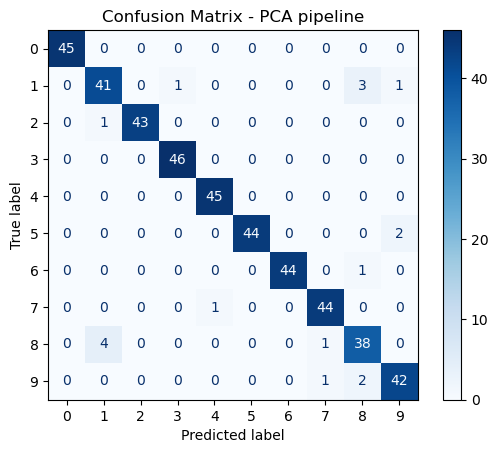

In [31]:
# 9: Confusion Matrix
ConfusionMatrixDisplay.from_estimator(with_pca, X_test, y_test, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - PCA pipeline")
plt.show()